In [35]:
import requests
import pandas as pd
import io

# Define the SPARQL endpoint
endpoint = "https://www.govdata.de/sparql"

# Get the proxy URL
proxy_url = requests.utils.getproxies().get('http')

# Set the proxy configuration
proxies = {'http': proxy_url}



query = """
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcatde: <http://dcat-ap.de/def/dcatde/>

SELECT ?dataset ?title ?publication_date ?publisher_name ?distribution_link WHERE {
  ?dataset dcat:distribution ?distribution .
  ?dataset dct:publisher ?publisher .
  ?dataset dct:title ?title .
  ?dataset dct:issued ?publication_date .
  ?publisher foaf:name ?publisher_name .
  OPTIONAL { ?distribution dcat:accessURL ?distribution_link . }
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*'))
}
"""

# Send the SPARQL query and get the response in CSV format
url = endpoint + '?query=' + requests.utils.quote(query, safe='')
headers = {'Accept': 'text/csv'}
response = requests.get(url, headers=headers, proxies=proxies, timeout=60)

# Convert the CSV response to a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

In [2]:
# Get only distinct datasets
df_distinct = df.drop_duplicates(subset=['dataset'])

In [3]:
# Count the number of datasets per publisher
df_distinct_publ = df_distinct['publisher_name'].value_counts()
print(df_distinct_publ)

Bundesministerium für Familie, Senioren, Frauen und Jugend                                                                          60
Bundesministerium für Arbeit und Soziales                                                                                           60
Bundesministerium der Finanzen                                                                                                      53
Bundesministerium für Wirtschaft und Energie                                                                                        20
Bundesministerium des Innern                                                                                                        18
Bundesministerium für Wohnen, Stadtentwicklung und Bauwesen                                                                         10
Bundesministerium für Digitales und Verkehr (BMDV)                                                                                   6
Bundesministerium für Ernährung und Landwirtschaft; Ref

In [50]:
random_rows = df.sample(n=100)

In [51]:
import requests

# List of URLs to check
urls = random_rows.distribution_link
# Create a list of dictionaries to store the results
results = []

# Check the status of each URL and store the result in the list of dictionaries
for url in urls:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            status = "OK"
        else:
            status = f"Error {response.status_code}"
    except requests.exceptions.RequestException as e:
        status = f"Error {e}"
    results.append({"url": url, "status": status})

# Create a DataFrame from the list of dictionaries
results_url_status = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_url_status.to_csv("output/results_url_status.csv", index=False)

# Print the DataFrame
print(results_url_status)



                                                  url status
0   https://www.bundesfinanzministerium.de/Datenpo...     OK
1   https://www.bundesfinanzministerium.de/Portal-...     OK
2   https://www.bundesfinanzministerium.de/Datenpo...     OK
3   https://www.bmas.de/SharedDocs/Downloads/DE/Pu...     OK
4   https://www.bmas.de/SharedDocs/Downloads/DE/Pu...     OK
..                                                ...    ...
95                  https://gigabit-projekttraeger.de     OK
96  https://www.bundesfinanzministerium.de/Datenpo...     OK
97  https://teamwork.bmz.de/pub/bscw.cgi/2018133/D...     OK
98  https://www.bundesfinanzministerium.de/Datenpo...     OK
99  https://www.bundesfinanzministerium.de/Datenpo...     OK

[100 rows x 2 columns]


In [54]:
(results_url_status["status"] == "OK").sum()

68

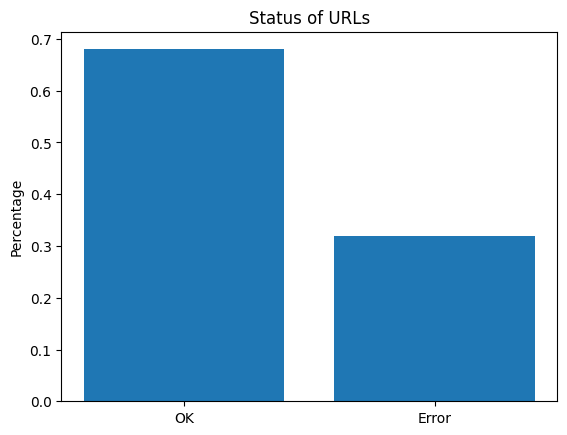

In [56]:
import matplotlib.pyplot as plt

# Replace all non-"OK" cells in the "status" column with "Error"
results_url_status.loc[results_url_status["status"] != "OK", "status"] = "Error"

# Group the DataFrame by status and count the number of URLs with each status
grouped = results_url_status.groupby("status").size()

# Calculate the percentage of "OK" and "Error" values
ok_percent = (results_url_status["status"] == "OK").sum() / len(results_url_status)
error_percent = (results_url_status["status"] == "Error").sum() / len(results_url_status)

# Plot the percentages as a bar chart
plt.bar(["OK", "Error"], [ok_percent, error_percent])
plt.ylabel("Percentage")
plt.title("Status of URLs")
plt.show()